In [1]:
from lib_linear import *
import  time
import torch.nn.functional as F

input_input_matrix = np.array(pd.read_csv('input_input_matrix.csv'))
output_input_matrix = np.array(pd.read_csv('output_input_matrix.csv'))
output_output_matrix = np.array(pd.read_csv('output_output_matrix.csv'))

V_matrix = np.array(pd.read_csv('V_matrix.csv'))
U_matrix = np.array(pd.read_csv('U_matrix.csv'))
S31_matrix = np.array(pd.read_csv('S_matrix.csv'))  ##actually, just diag values

S11_matrix = V_matrix.T @ input_input_matrix @ V_matrix
S33_matrix = output_output_matrix


## Data

In [2]:
mean, std = calculate_mean_and_std()
train_data, test_data =  download_normalized_data(mean, std)

## Neural network model

In [3]:
class CustomNetwork(object):
    
    """
    Simple D-layer linear neural network 
    hidden_dims = topule(n0, n1, n2, ...nD)
    n0 = input layer
    n_D = output layer
    """
    
    def __init__(self, D, layers_dim):
        
        """
        Initialize network's weights according to Gaussian iid and network's biases with 0.0 values
        """
        
        self.weights = []
        
        self.D = len(layers_dim)-1
        assert self.D == D
        
        print("Depth of the network = number of hidden layers + 1:", D)
        
        for i in range(self.D):
            
            weight: torch.Tensor = torch.rand((layers_dim[i+1], layers_dim[i])) 
            
            stdv = 2/ np.sqrt(layers_dim[i])
            
            weight = (weight-0.5)*stdv

            weight.requires_grad = True
            
            self.weights.append(weight)
       
            
    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the network
        """

        for i in range(0,self.D):            
            x = torch.nn.functional.linear( input = x, weight=self.weights[i])
        return x 
    
    
    
    def parameters(self) -> List[torch.Tensor]:
        """
        Returns all trainable parameters 
        """
        return self.weights

In [4]:
input_dim = 784
output_dim = 10
hidden_dim1 = 400

D = 2

# initialize the model
model: CustomNetwork = CustomNetwork(D = D, layers_dim = (input_dim, hidden_dim1, output_dim))

Depth of the network = number of hidden layers + 1: 2


## Training parameters

In [5]:
# initialize the optimizer using the hyperparams below
lr: float = 0.005
momentum: float = 0.00
optimizer: torch.optim.Optimizer = SGD(params = model.parameters(), lr=lr)
criterion = nn.MSELoss() 
epoch: int = 3000

## Training loop

In [6]:
term_I_tab=[]
term_II_tab = []
term_IV_tab = []
MSE_tab = []
R_tab = []

In [7]:
batch_size: int = 1000 
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size) 
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

for e in range(epoch):
    for inner_counter, (x, y) in enumerate(train_loader):

        # reset the gradients from previouis iteration
        optimizer.zero_grad()

        # pass through the network
        output: torch.Tensor = model(x)  
        y=F.one_hot(y, num_classes=10).float()
        loss: torch.Tensor = criterion(output, y)

        # backward pass thorught the network
        loss.backward()

        # apply the gradients
        optimizer.step()     

    
    #add model parameters to tab
    loss_tab.append(loss.item())
    params_tab = []
    for param in model.parameters():
        params_tab.append(param.detach().numpy().flatten()  )

    w1_mean_tab.append(params_tab[0].mean())
    w2_mean_tab.append(params_tab[1].mean())
    w1_std_tab.append(params_tab[0].std())
    w2_std_tab.append(params_tab[1].std())


    # at the end of an epoch run evaluation on the test set
    with torch.no_grad():
        correct: int = 0 
        for i, (x, y) in enumerate(train_loader):
            # pass through the network            
            output: torch.Tensor = model(x)
            # update the number of correctly predicted examples
            pred_labels = torch.argmax(output, 1)
            correct += ( (pred_labels -y) ==0).sum()
        train_accuracy_tab.append( float(correct) / len(train_data))

        correct: int = 0 
        for i, (x, y) in enumerate(test_loader):
            # pass through the network            
            output: torch.Tensor = model(x)

            # update the number of correctly predicted examples
            pred_labels = torch.argmax(output, 1)
            correct += ( (pred_labels -y) ==0).sum()
        test_accuracy_tab.append( float(correct) / len(test_data))

    ########################################################################
    params=[]
    for param in model.parameters():
        params.append(param.detach().numpy())
    w1=params[0] 
    w2=params[1]

    R = U_matrix.T @ w2 @ w1 @ V_matrix

    term_1 = 0
    for alpha in range(10):
        term_1 += (R[alpha][alpha] - S31_matrix[alpha]/S11_matrix[alpha][alpha])**2 * S11_matrix[alpha][alpha]

    term_2 = 0
    for beta in range(10):
        for alpha in range(784):
            if(alpha != beta):
                term_2 += (R[beta][alpha])**2 *S11_matrix[alpha][alpha]

    term_4 = 0
    for alpha in range(10):
        term_4+= (R[alpha][alpha])**2*S11_matrix[alpha][alpha]
    
    term_I_tab.append(term_1)
    term_II_tab.append(term_2)
    term_IV_tab.append(term_4)
    R_tab.append(R)

    term_1 = round(float(term_1), 6)
    term_2 = round(term_2, 6)

    check = round(1+ term_2 - term_4, 6)
    check2 = round(1+ term_1 + term_2 - term_4, 6)

    print(f"{e}\t{loss} \t term1: {term_1}, \t term2: {term_2} \t {check}\t {check2}")   



0	0.09709622710943222 	 term1: 0.103195, 	 term2: 0.416712 	 1.177902	 1.281097
1	0.07724600285291672 	 term1: 0.035632, 	 term2: 0.317627 	 0.957855	 0.993487
2	0.0681445449590683 	 term1: 0.015225, 	 term2: 0.266203 	 0.832367	 0.847592
3	0.06264615803956985 	 term1: 0.007639, 	 term2: 0.234565 	 0.752871	 0.76051
4	0.05888134613633156 	 term1: 0.004769, 	 term2: 0.213433 	 0.698211	 0.70298
5	0.056117407977581024 	 term1: 0.003938, 	 term2: 0.198557 	 0.658347	 0.662285
6	0.05399267002940178 	 term1: 0.004067, 	 term2: 0.187676 	 0.628001	 0.632068
7	0.052303627133369446 	 term1: 0.004658, 	 term2: 0.179477 	 0.604148	 0.608806
8	0.050925854593515396 	 term1: 0.005466, 	 term2: 0.17315 	 0.58493	 0.590396
9	0.04977862909436226 	 term1: 0.006361, 	 term2: 0.168168 	 0.569132	 0.575493
10	0.04880716651678085 	 term1: 0.007274, 	 term2: 0.164178 	 0.555931	 0.563205
11	0.04797288030385971 	 term1: 0.008169, 	 term2: 0.160933 	 0.544742	 0.552911
12	0.04724779725074768 	 term1: 0.009027

102	0.03723965957760811 	 term1: 0.029284, 	 term2: 0.140896 	 0.414004	 0.443288
103	0.03721535578370094 	 term1: 0.029366, 	 term2: 0.140942 	 0.413734	 0.4431
104	0.037191398441791534 	 term1: 0.029447, 	 term2: 0.140989 	 0.413469	 0.442916
105	0.037167783826589584 	 term1: 0.029527, 	 term2: 0.141035 	 0.413206	 0.442733
106	0.0371444895863533 	 term1: 0.029606, 	 term2: 0.141082 	 0.412948	 0.442554
107	0.03712151572108269 	 term1: 0.029684, 	 term2: 0.141129 	 0.412694	 0.442378
108	0.03709885850548744 	 term1: 0.029762, 	 term2: 0.141177 	 0.412444	 0.442206
109	0.03707650676369667 	 term1: 0.029838, 	 term2: 0.141224 	 0.412197	 0.442035
110	0.037054456770420074 	 term1: 0.029914, 	 term2: 0.141272 	 0.411955	 0.441869
111	0.03703269362449646 	 term1: 0.029989, 	 term2: 0.14132 	 0.411715	 0.441704
112	0.037011224776506424 	 term1: 0.030064, 	 term2: 0.141368 	 0.411479	 0.441543
113	0.036990027874708176 	 term1: 0.030137, 	 term2: 0.141416 	 0.411247	 0.441384
114	0.036969106

203	0.03577046096324921 	 term1: 0.03478, 	 term2: 0.14571 	 0.398538	 0.433318
204	0.035761598497629166 	 term1: 0.034817, 	 term2: 0.145754 	 0.398452	 0.433269
205	0.0357527993619442 	 term1: 0.034854, 	 term2: 0.145798 	 0.398367	 0.433221
206	0.035744063556194305 	 term1: 0.03489, 	 term2: 0.145842 	 0.398282	 0.433172
207	0.03573539853096008 	 term1: 0.034927, 	 term2: 0.145885 	 0.398197	 0.433124
208	0.03572678938508034 	 term1: 0.034963, 	 term2: 0.145929 	 0.398114	 0.433077
209	0.03571823611855507 	 term1: 0.034998, 	 term2: 0.145972 	 0.398031	 0.433029
210	0.03570975363254547 	 term1: 0.035034, 	 term2: 0.146016 	 0.39795	 0.432984
211	0.03570132330060005 	 term1: 0.035069, 	 term2: 0.146059 	 0.397869	 0.432938
212	0.0356929637491703 	 term1: 0.035105, 	 term2: 0.146102 	 0.397788	 0.432893
213	0.035684652626514435 	 term1: 0.03514, 	 term2: 0.146145 	 0.397708	 0.432848
214	0.03567640855908394 	 term1: 0.035174, 	 term2: 0.146188 	 0.397629	 0.432803
215	0.03566821292042

304	0.035112686455249786 	 term1: 0.037656, 	 term2: 0.149591 	 0.392443	 0.430099
305	0.03510791063308716 	 term1: 0.037678, 	 term2: 0.149624 	 0.392401	 0.430079
306	0.03510316461324692 	 term1: 0.0377, 	 term2: 0.149657 	 0.39236	 0.43006
307	0.03509844094514847 	 term1: 0.037722, 	 term2: 0.14969 	 0.392318	 0.43004
308	0.035093750804662704 	 term1: 0.037743, 	 term2: 0.149723 	 0.392277	 0.43002
309	0.03508907929062843 	 term1: 0.037765, 	 term2: 0.149756 	 0.392237	 0.430002
310	0.035084422677755356 	 term1: 0.037786, 	 term2: 0.149788 	 0.392196	 0.429982
311	0.03507980331778526 	 term1: 0.037808, 	 term2: 0.149821 	 0.392156	 0.429964
312	0.03507520258426666 	 term1: 0.037829, 	 term2: 0.149853 	 0.392115	 0.429944
313	0.035070620477199554 	 term1: 0.03785, 	 term2: 0.149885 	 0.392075	 0.429925
314	0.035066068172454834 	 term1: 0.037871, 	 term2: 0.149918 	 0.392036	 0.429907
315	0.035061538219451904 	 term1: 0.037892, 	 term2: 0.14995 	 0.391997	 0.429889
316	0.0350570306181

405	0.03473065048456192 	 term1: 0.039471, 	 term2: 0.1525 	 0.389209	 0.42868
406	0.034727662801742554 	 term1: 0.039485, 	 term2: 0.152525 	 0.389185	 0.42867
407	0.03472469374537468 	 term1: 0.0395, 	 term2: 0.15255 	 0.389161	 0.428661
408	0.0347217358648777 	 term1: 0.039515, 	 term2: 0.152574 	 0.389136	 0.428651
409	0.03471878543496132 	 term1: 0.039529, 	 term2: 0.152599 	 0.389112	 0.428641
410	0.034715861082077026 	 term1: 0.039544, 	 term2: 0.152624 	 0.389088	 0.428632
411	0.03471294045448303 	 term1: 0.039558, 	 term2: 0.152648 	 0.389064	 0.428622
412	0.034710027277469635 	 term1: 0.039572, 	 term2: 0.152673 	 0.389041	 0.428613
413	0.03470713272690773 	 term1: 0.039587, 	 term2: 0.152697 	 0.389017	 0.428604
414	0.03470424935221672 	 term1: 0.039601, 	 term2: 0.152722 	 0.388994	 0.428595
415	0.03470137342810631 	 term1: 0.039615, 	 term2: 0.152746 	 0.388971	 0.428586
416	0.03469851240515709 	 term1: 0.039629, 	 term2: 0.15277 	 0.388947	 0.428576
417	0.0346956625580787

506	0.034481801092624664 	 term1: 0.040725, 	 term2: 0.15471 	 0.387227	 0.427952
507	0.0344797745347023 	 term1: 0.040735, 	 term2: 0.154729 	 0.387211	 0.427946
508	0.03447775915265083 	 term1: 0.040746, 	 term2: 0.154748 	 0.387195	 0.427941
509	0.03447575494647026 	 term1: 0.040756, 	 term2: 0.154767 	 0.387179	 0.427935
510	0.03447374701499939 	 term1: 0.040767, 	 term2: 0.154786 	 0.387164	 0.427931
511	0.034471750259399414 	 term1: 0.040777, 	 term2: 0.154805 	 0.387148	 0.427925
512	0.03446975722908974 	 term1: 0.040787, 	 term2: 0.154824 	 0.387133	 0.42792
513	0.034467775374650955 	 term1: 0.040798, 	 term2: 0.154843 	 0.387118	 0.427916
514	0.03446580469608307 	 term1: 0.040808, 	 term2: 0.154861 	 0.387102	 0.42791
515	0.03446383774280548 	 term1: 0.040818, 	 term2: 0.15488 	 0.387087	 0.427905
516	0.03446187824010849 	 term1: 0.040828, 	 term2: 0.154899 	 0.387072	 0.4279
517	0.0344599187374115 	 term1: 0.040838, 	 term2: 0.154917 	 0.387056	 0.427894
518	0.034457974135875

607	0.034308332949876785 	 term1: 0.041642, 	 term2: 0.156426 	 0.385899	 0.427541
608	0.034306880086660385 	 term1: 0.04165, 	 term2: 0.156441 	 0.385888	 0.427538
609	0.03430543094873428 	 term1: 0.041658, 	 term2: 0.156456 	 0.385877	 0.427535
610	0.03430399298667908 	 term1: 0.041666, 	 term2: 0.156471 	 0.385866	 0.427532
611	0.03430255874991417 	 term1: 0.041673, 	 term2: 0.156486 	 0.385855	 0.427528
612	0.03430112451314926 	 term1: 0.041681, 	 term2: 0.156501 	 0.385845	 0.427526
613	0.03429969400167465 	 term1: 0.041689, 	 term2: 0.156516 	 0.385834	 0.427523
614	0.03429827094078064 	 term1: 0.041697, 	 term2: 0.15653 	 0.385823	 0.42752
615	0.034296855330467224 	 term1: 0.041704, 	 term2: 0.156545 	 0.385812	 0.427516
616	0.03429543972015381 	 term1: 0.041712, 	 term2: 0.15656 	 0.385802	 0.427514
617	0.03429403156042099 	 term1: 0.04172, 	 term2: 0.156575 	 0.385791	 0.427511
618	0.03429262340068817 	 term1: 0.041727, 	 term2: 0.156589 	 0.38578	 0.427507
619	0.0342912152409

708	0.03418168053030968 	 term1: 0.042341, 	 term2: 0.157788 	 0.384954	 0.427295
709	0.03418060764670372 	 term1: 0.042347, 	 term2: 0.1578 	 0.384946	 0.427293
710	0.034179527312517166 	 term1: 0.042353, 	 term2: 0.157812 	 0.384938	 0.427291
711	0.03417845442891121 	 term1: 0.042359, 	 term2: 0.157824 	 0.38493	 0.427289
712	0.03417738527059555 	 term1: 0.042365, 	 term2: 0.157836 	 0.384922	 0.427287
713	0.03417631611227989 	 term1: 0.042371, 	 term2: 0.157847 	 0.384913	 0.427284
714	0.03417525067925453 	 term1: 0.042377, 	 term2: 0.157859 	 0.384905	 0.427282
715	0.03417418897151947 	 term1: 0.042383, 	 term2: 0.157871 	 0.384897	 0.42728
716	0.03417313098907471 	 term1: 0.042389, 	 term2: 0.157883 	 0.38489	 0.427279
717	0.034172069281339645 	 term1: 0.042395, 	 term2: 0.157895 	 0.384882	 0.427277
718	0.03417101874947548 	 term1: 0.042401, 	 term2: 0.157907 	 0.384874	 0.427275
719	0.03416997194290161 	 term1: 0.042407, 	 term2: 0.157919 	 0.384867	 0.427274
720	0.0341689214110

809	0.03408602252602577 	 term1: 0.042889, 	 term2: 0.158888 	 0.384248	 0.427137
810	0.034085195511579514 	 term1: 0.042894, 	 term2: 0.158897 	 0.384242	 0.427136
811	0.034084368497133255 	 term1: 0.042899, 	 term2: 0.158907 	 0.384236	 0.427135
812	0.034083545207977295 	 term1: 0.042904, 	 term2: 0.158917 	 0.38423	 0.427134
813	0.034082721918821335 	 term1: 0.042909, 	 term2: 0.158927 	 0.384224	 0.427133
814	0.03408190608024597 	 term1: 0.042913, 	 term2: 0.158936 	 0.384217	 0.42713
815	0.03408108651638031 	 term1: 0.042918, 	 term2: 0.158946 	 0.384211	 0.427129
816	0.034080274403095245 	 term1: 0.042923, 	 term2: 0.158956 	 0.384206	 0.427129
817	0.03407946228981018 	 term1: 0.042928, 	 term2: 0.158966 	 0.3842	 0.427128
818	0.034078650176525116 	 term1: 0.042933, 	 term2: 0.158975 	 0.384194	 0.427127
819	0.03407784178853035 	 term1: 0.042937, 	 term2: 0.158985 	 0.384188	 0.427125
820	0.034077029675245285 	 term1: 0.042942, 	 term2: 0.158994 	 0.384181	 0.427123
821	0.0340762

910	0.0340118408203125 	 term1: 0.04333, 	 term2: 0.15979 	 0.383702	 0.427032
911	0.03401119261980057 	 term1: 0.043334, 	 term2: 0.159799 	 0.383698	 0.427032
912	0.034010544419288635 	 term1: 0.043338, 	 term2: 0.159807 	 0.383693	 0.427031
913	0.0340098962187767 	 term1: 0.043342, 	 term2: 0.159815 	 0.383688	 0.42703
914	0.03400924801826477 	 term1: 0.043346, 	 term2: 0.159823 	 0.383684	 0.42703
915	0.034008607268333435 	 term1: 0.04335, 	 term2: 0.159831 	 0.383679	 0.427029
916	0.0340079665184021 	 term1: 0.043354, 	 term2: 0.159839 	 0.383674	 0.427028
917	0.034007325768470764 	 term1: 0.043358, 	 term2: 0.159847 	 0.383669	 0.427027
918	0.03400668501853943 	 term1: 0.043362, 	 term2: 0.159855 	 0.383665	 0.427027
919	0.03400604799389839 	 term1: 0.043366, 	 term2: 0.159863 	 0.38366	 0.427026
920	0.03400541469454765 	 term1: 0.043369, 	 term2: 0.159871 	 0.383655	 0.427024
921	0.034004777669906616 	 term1: 0.043373, 	 term2: 0.159879 	 0.383651	 0.427024
922	0.034004144370555

1010	0.03395361825823784 	 term1: 0.043689, 	 term2: 0.160535 	 0.383272	 0.426961
1011	0.033953092992305756 	 term1: 0.043692, 	 term2: 0.160542 	 0.383268	 0.42696
1012	0.03395257517695427 	 term1: 0.043696, 	 term2: 0.160549 	 0.383264	 0.42696
1013	0.03395205736160278 	 term1: 0.043699, 	 term2: 0.160556 	 0.383261	 0.42696
1014	0.0339515395462513 	 term1: 0.043702, 	 term2: 0.160563 	 0.383257	 0.426959
1015	0.03395102545619011 	 term1: 0.043705, 	 term2: 0.160569 	 0.383252	 0.426957
1016	0.03395051136612892 	 term1: 0.043709, 	 term2: 0.160576 	 0.383249	 0.426958
1017	0.033949993550777435 	 term1: 0.043712, 	 term2: 0.160583 	 0.383245	 0.426957
1018	0.033949486911296844 	 term1: 0.043715, 	 term2: 0.16059 	 0.383242	 0.426957
1019	0.03394897282123566 	 term1: 0.043718, 	 term2: 0.160596 	 0.383237	 0.426955
1020	0.03394846245646477 	 term1: 0.043721, 	 term2: 0.160603 	 0.383234	 0.426955
1021	0.03394795581698418 	 term1: 0.043725, 	 term2: 0.16061 	 0.38323	 0.426955
1022	0.0

1110	0.033906616270542145 	 term1: 0.043989, 	 term2: 0.161164 	 0.38292	 0.426909
1111	0.03390619158744812 	 term1: 0.043991, 	 term2: 0.16117 	 0.382917	 0.426908
1112	0.033905766904354095 	 term1: 0.043994, 	 term2: 0.161176 	 0.382914	 0.426908
1113	0.03390534594655037 	 term1: 0.043997, 	 term2: 0.161181 	 0.38291	 0.426907
1114	0.03390492498874664 	 term1: 0.044, 	 term2: 0.161187 	 0.382907	 0.426907
1115	0.03390450403094292 	 term1: 0.044002, 	 term2: 0.161193 	 0.382904	 0.426906
1116	0.03390408307313919 	 term1: 0.044005, 	 term2: 0.161199 	 0.382901	 0.426906
1117	0.03390366584062576 	 term1: 0.044008, 	 term2: 0.161204 	 0.382897	 0.426905
1118	0.033903248608112335 	 term1: 0.04401, 	 term2: 0.16121 	 0.382895	 0.426905
1119	0.033902835100889206 	 term1: 0.044013, 	 term2: 0.161216 	 0.382892	 0.426905
1120	0.03390241786837578 	 term1: 0.044016, 	 term2: 0.161222 	 0.382889	 0.426905
1121	0.03390200063586235 	 term1: 0.044019, 	 term2: 0.161227 	 0.382885	 0.426904
1122	0.0

1209	0.03386847674846649 	 term1: 0.04424, 	 term2: 0.161696 	 0.382629	 0.426869
1210	0.033868126571178436 	 term1: 0.044243, 	 term2: 0.161701 	 0.382627	 0.42687
1211	0.03386777639389038 	 term1: 0.044245, 	 term2: 0.161706 	 0.382624	 0.426869
1212	0.033867429941892624 	 term1: 0.044247, 	 term2: 0.161711 	 0.382621	 0.426868
1213	0.03386708348989487 	 term1: 0.04425, 	 term2: 0.161716 	 0.382619	 0.426869
1214	0.03386673703789711 	 term1: 0.044252, 	 term2: 0.161721 	 0.382616	 0.426868
1215	0.03386639058589935 	 term1: 0.044254, 	 term2: 0.161726 	 0.382614	 0.426868
1216	0.033866047859191895 	 term1: 0.044257, 	 term2: 0.161731 	 0.382611	 0.426868
1217	0.03386569768190384 	 term1: 0.044259, 	 term2: 0.161735 	 0.382607	 0.426866
1218	0.03386535495519638 	 term1: 0.044261, 	 term2: 0.16174 	 0.382605	 0.426866
1219	0.03386501595377922 	 term1: 0.044263, 	 term2: 0.161745 	 0.382602	 0.426865
1220	0.033864669501781464 	 term1: 0.044266, 	 term2: 0.16175 	 0.3826	 0.426866
1221	0.

1309	0.033836543560028076 	 term1: 0.044458, 	 term2: 0.162159 	 0.382379	 0.426837
1310	0.0338362492620945 	 term1: 0.04446, 	 term2: 0.162164 	 0.382378	 0.426838
1311	0.03383595496416092 	 term1: 0.044462, 	 term2: 0.162168 	 0.382375	 0.426837
1312	0.03383566811680794 	 term1: 0.044464, 	 term2: 0.162172 	 0.382372	 0.426836
1313	0.033835381269454956 	 term1: 0.044467, 	 term2: 0.162177 	 0.382371	 0.426838
1314	0.033835090696811676 	 term1: 0.044469, 	 term2: 0.162181 	 0.382368	 0.426837
1315	0.033834803849458694 	 term1: 0.044471, 	 term2: 0.162185 	 0.382366	 0.426837
1316	0.03383451700210571 	 term1: 0.044473, 	 term2: 0.16219 	 0.382364	 0.426837
1317	0.03383423015475273 	 term1: 0.044475, 	 term2: 0.162194 	 0.382362	 0.426837
1318	0.03383393585681915 	 term1: 0.044477, 	 term2: 0.162198 	 0.382359	 0.426836
1319	0.03383364900946617 	 term1: 0.044479, 	 term2: 0.162202 	 0.382357	 0.426836
1320	0.03383336588740349 	 term1: 0.044481, 	 term2: 0.162207 	 0.382355	 0.426836
132

1408	0.03381003439426422 	 term1: 0.044646, 	 term2: 0.162559 	 0.382167	 0.426813
1409	0.03380978852510452 	 term1: 0.044648, 	 term2: 0.162563 	 0.382165	 0.426813
1410	0.033809542655944824 	 term1: 0.044649, 	 term2: 0.162567 	 0.382163	 0.426812
1411	0.033809300512075424 	 term1: 0.044651, 	 term2: 0.16257 	 0.382161	 0.426812
1412	0.03380905091762543 	 term1: 0.044653, 	 term2: 0.162574 	 0.382159	 0.426812
1413	0.033808812499046326 	 term1: 0.044655, 	 term2: 0.162578 	 0.382157	 0.426812
1414	0.033808570355176926 	 term1: 0.044656, 	 term2: 0.162582 	 0.382155	 0.426811
1415	0.033808328211307526 	 term1: 0.044658, 	 term2: 0.162585 	 0.382153	 0.426811
1416	0.03380808234214783 	 term1: 0.04466, 	 term2: 0.162589 	 0.382151	 0.426811
1417	0.03380783647298813 	 term1: 0.044662, 	 term2: 0.162593 	 0.382149	 0.426811
1418	0.03380759805440903 	 term1: 0.044664, 	 term2: 0.162597 	 0.382147	 0.426811
1419	0.03380735591053963 	 term1: 0.044665, 	 term2: 0.1626 	 0.382145	 0.42681
1420

1507	0.03378760814666748 	 term1: 0.04481, 	 term2: 0.16291 	 0.381981	 0.426791
1508	0.03378739953041077 	 term1: 0.044812, 	 term2: 0.162914 	 0.38198	 0.426792
1509	0.03378719091415405 	 term1: 0.044814, 	 term2: 0.162917 	 0.381978	 0.426792
1510	0.03378698602318764 	 term1: 0.044815, 	 term2: 0.16292 	 0.381976	 0.426791
1511	0.03378677740693092 	 term1: 0.044817, 	 term2: 0.162924 	 0.381975	 0.426792
1512	0.03378656879067421 	 term1: 0.044818, 	 term2: 0.162927 	 0.381973	 0.426791
1513	0.033786360174417496 	 term1: 0.04482, 	 term2: 0.16293 	 0.381971	 0.426791
1514	0.03378615528345108 	 term1: 0.044821, 	 term2: 0.162934 	 0.38197	 0.426791
1515	0.033785950392484665 	 term1: 0.044823, 	 term2: 0.162937 	 0.381968	 0.426791
1516	0.03378574177622795 	 term1: 0.044824, 	 term2: 0.16294 	 0.381965	 0.426789
1517	0.033785536885261536 	 term1: 0.044826, 	 term2: 0.162944 	 0.381964	 0.42679
1518	0.03378533199429512 	 term1: 0.044827, 	 term2: 0.162947 	 0.381962	 0.426789
1519	0.033

1606	0.03376846760511398 	 term1: 0.044956, 	 term2: 0.163221 	 0.381817	 0.426773
1607	0.03376828879117966 	 term1: 0.044957, 	 term2: 0.163224 	 0.381816	 0.426773
1608	0.03376810997724533 	 term1: 0.044959, 	 term2: 0.163227 	 0.381814	 0.426773
1609	0.0337679348886013 	 term1: 0.04496, 	 term2: 0.16323 	 0.381813	 0.426773
1610	0.03376775607466698 	 term1: 0.044961, 	 term2: 0.163233 	 0.381811	 0.426772
1611	0.03376757726073265 	 term1: 0.044963, 	 term2: 0.163236 	 0.38181	 0.426773
1612	0.033767394721508026 	 term1: 0.044964, 	 term2: 0.163239 	 0.381808	 0.426772
1613	0.033767219632864 	 term1: 0.044966, 	 term2: 0.163242 	 0.381807	 0.426773
1614	0.03376704826951027 	 term1: 0.044967, 	 term2: 0.163245 	 0.381805	 0.426772
1615	0.033766865730285645 	 term1: 0.044968, 	 term2: 0.163248 	 0.381804	 0.426772
1616	0.033766694366931915 	 term1: 0.04497, 	 term2: 0.163251 	 0.381803	 0.426773
1617	0.03376651555299759 	 term1: 0.044971, 	 term2: 0.163254 	 0.381801	 0.426772
1618	0.0

1705	0.03375200554728508 	 term1: 0.045086, 	 term2: 0.163499 	 0.381673	 0.426759
1706	0.03375185281038284 	 term1: 0.045087, 	 term2: 0.163502 	 0.381672	 0.426759
1707	0.03375169634819031 	 term1: 0.045088, 	 term2: 0.163504 	 0.38167	 0.426758
1708	0.03375153988599777 	 term1: 0.045089, 	 term2: 0.163507 	 0.381669	 0.426758
1709	0.033751390874385834 	 term1: 0.04509, 	 term2: 0.163509 	 0.381667	 0.426757
1710	0.0337512344121933 	 term1: 0.045092, 	 term2: 0.163512 	 0.381665	 0.426757
1711	0.03375108167529106 	 term1: 0.045093, 	 term2: 0.163515 	 0.381664	 0.426757
1712	0.033750928938388824 	 term1: 0.045094, 	 term2: 0.163517 	 0.381662	 0.426756
1713	0.033750779926776886 	 term1: 0.045095, 	 term2: 0.16352 	 0.381661	 0.426756
1714	0.03375062718987465 	 term1: 0.045097, 	 term2: 0.163523 	 0.38166	 0.426757
1715	0.033750470727682114 	 term1: 0.045098, 	 term2: 0.163525 	 0.381658	 0.426756
1716	0.033750321716070175 	 term1: 0.045099, 	 term2: 0.163528 	 0.381657	 0.426756
1717

1805	0.03373763710260391 	 term1: 0.045203, 	 term2: 0.16375 	 0.38154	 0.426743
1806	0.03373750299215317 	 term1: 0.045204, 	 term2: 0.163753 	 0.38154	 0.426744
1807	0.03373737260699272 	 term1: 0.045205, 	 term2: 0.163755 	 0.381538	 0.426743
1808	0.03373723849654198 	 term1: 0.045206, 	 term2: 0.163758 	 0.381537	 0.426743
1809	0.03373710438609123 	 term1: 0.045208, 	 term2: 0.16376 	 0.381536	 0.426744
1810	0.03373697027564049 	 term1: 0.045209, 	 term2: 0.163762 	 0.381534	 0.426743
1811	0.03373683616518974 	 term1: 0.04521, 	 term2: 0.163765 	 0.381533	 0.426743
1812	0.033736702054739 	 term1: 0.045211, 	 term2: 0.163767 	 0.381532	 0.426743
1813	0.03373657166957855 	 term1: 0.045212, 	 term2: 0.163769 	 0.38153	 0.426742
1814	0.03373643755912781 	 term1: 0.045213, 	 term2: 0.163772 	 0.38153	 0.426743
1815	0.03373630717396736 	 term1: 0.045214, 	 term2: 0.163774 	 0.381528	 0.426742
1816	0.033736176788806915 	 term1: 0.045215, 	 term2: 0.163777 	 0.381528	 0.426743
1817	0.03373

1905	0.03372512757778168 	 term1: 0.045309, 	 term2: 0.163977 	 0.381422	 0.426731
1906	0.033725012093782425 	 term1: 0.04531, 	 term2: 0.16398 	 0.381421	 0.426731
1907	0.03372489660978317 	 term1: 0.045311, 	 term2: 0.163982 	 0.38142	 0.426731
1908	0.03372477740049362 	 term1: 0.045312, 	 term2: 0.163984 	 0.381419	 0.426731
1909	0.03372466564178467 	 term1: 0.045313, 	 term2: 0.163986 	 0.381418	 0.426731
1910	0.03372454270720482 	 term1: 0.045314, 	 term2: 0.163988 	 0.381416	 0.42673
1911	0.033724430948495865 	 term1: 0.045315, 	 term2: 0.16399 	 0.381415	 0.42673
1912	0.03372431546449661 	 term1: 0.045316, 	 term2: 0.163992 	 0.381414	 0.42673
1913	0.03372419998049736 	 term1: 0.045317, 	 term2: 0.163995 	 0.381413	 0.42673
1914	0.03372408449649811 	 term1: 0.045318, 	 term2: 0.163997 	 0.381412	 0.42673
1915	0.033723969012498856 	 term1: 0.045319, 	 term2: 0.163999 	 0.381411	 0.42673
1916	0.0337238535284996 	 term1: 0.04532, 	 term2: 0.164001 	 0.38141	 0.42673
1917	0.03372373

2004	0.03371427580714226 	 term1: 0.045404, 	 term2: 0.164181 	 0.381315	 0.426719
2005	0.0337141789495945 	 term1: 0.045405, 	 term2: 0.164183 	 0.381314	 0.426719
2006	0.03371407464146614 	 term1: 0.045406, 	 term2: 0.164185 	 0.381313	 0.426719
2007	0.033713970333337784 	 term1: 0.045407, 	 term2: 0.164187 	 0.381312	 0.426719
2008	0.033713873475790024 	 term1: 0.045408, 	 term2: 0.164189 	 0.381311	 0.426719
2009	0.03371376544237137 	 term1: 0.045409, 	 term2: 0.164191 	 0.38131	 0.426719
2010	0.03371366485953331 	 term1: 0.04541, 	 term2: 0.164193 	 0.381309	 0.426719
2011	0.03371356427669525 	 term1: 0.045411, 	 term2: 0.164195 	 0.381308	 0.426719
2012	0.03371346369385719 	 term1: 0.045412, 	 term2: 0.164197 	 0.381307	 0.426719
2013	0.033713363111019135 	 term1: 0.045413, 	 term2: 0.164199 	 0.381306	 0.426719
2014	0.03371325880289078 	 term1: 0.045414, 	 term2: 0.164201 	 0.381305	 0.426719
2015	0.03371315822005272 	 term1: 0.045415, 	 term2: 0.164203 	 0.381304	 0.426719
2016

2103	0.0337047278881073 	 term1: 0.045492, 	 term2: 0.164368 	 0.381218	 0.42671
2104	0.03370463475584984 	 term1: 0.045492, 	 term2: 0.16437 	 0.381217	 0.426709
2105	0.033704545348882675 	 term1: 0.045493, 	 term2: 0.164371 	 0.381215	 0.426708
2106	0.03370445594191551 	 term1: 0.045494, 	 term2: 0.164373 	 0.381215	 0.426709
2107	0.03370436653494835 	 term1: 0.045495, 	 term2: 0.164375 	 0.381214	 0.426709
2108	0.03370427340269089 	 term1: 0.045496, 	 term2: 0.164377 	 0.381213	 0.426709
2109	0.033704183995723724 	 term1: 0.045497, 	 term2: 0.164379 	 0.381213	 0.42671
2110	0.03370409458875656 	 term1: 0.045497, 	 term2: 0.16438 	 0.381211	 0.426708
2111	0.0337040051817894 	 term1: 0.045498, 	 term2: 0.164382 	 0.38121	 0.426708
2112	0.033703915774822235 	 term1: 0.045499, 	 term2: 0.164384 	 0.381209	 0.426708
2113	0.03370382636785507 	 term1: 0.0455, 	 term2: 0.164386 	 0.381209	 0.426709
2114	0.03370373696088791 	 term1: 0.045501, 	 term2: 0.164388 	 0.381208	 0.426709
2115	0.033

2203	0.03369617834687233 	 term1: 0.045572, 	 term2: 0.16454 	 0.381127	 0.426699
2204	0.03369610384106636 	 term1: 0.045573, 	 term2: 0.164542 	 0.381127	 0.4267
2205	0.033696021884679794 	 term1: 0.045574, 	 term2: 0.164544 	 0.381126	 0.4267
2206	0.03369593992829323 	 term1: 0.045575, 	 term2: 0.164545 	 0.381125	 0.4267
2207	0.03369586169719696 	 term1: 0.045575, 	 term2: 0.164547 	 0.381124	 0.426699
2208	0.033695779740810394 	 term1: 0.045576, 	 term2: 0.164549 	 0.381124	 0.4267
2209	0.03369570150971413 	 term1: 0.045577, 	 term2: 0.16455 	 0.381122	 0.426699
2210	0.03369561955332756 	 term1: 0.045578, 	 term2: 0.164552 	 0.381122	 0.4267
2211	0.03369554504752159 	 term1: 0.045578, 	 term2: 0.164554 	 0.381121	 0.426699
2212	0.033695463091135025 	 term1: 0.045579, 	 term2: 0.164555 	 0.381119	 0.426698
2213	0.03369538113474846 	 term1: 0.04558, 	 term2: 0.164557 	 0.381119	 0.426699
2214	0.03369529917836189 	 term1: 0.045581, 	 term2: 0.164559 	 0.381118	 0.426699
2215	0.0336952

2303	0.03368857875466347 	 term1: 0.045647, 	 term2: 0.164699 	 0.381044	 0.426691
2304	0.033688511699438095 	 term1: 0.045647, 	 term2: 0.164701 	 0.381044	 0.426691
2305	0.033688440918922424 	 term1: 0.045648, 	 term2: 0.164703 	 0.381043	 0.426691
2306	0.033688366413116455 	 term1: 0.045649, 	 term2: 0.164704 	 0.381042	 0.426691
2307	0.033688295632600784 	 term1: 0.045649, 	 term2: 0.164706 	 0.381042	 0.426691
2308	0.033688224852085114 	 term1: 0.04565, 	 term2: 0.164707 	 0.38104	 0.42669
2309	0.03368815407156944 	 term1: 0.045651, 	 term2: 0.164709 	 0.38104	 0.426691
2310	0.03368808329105377 	 term1: 0.045652, 	 term2: 0.16471 	 0.381039	 0.426691
2311	0.0336880125105381 	 term1: 0.045652, 	 term2: 0.164712 	 0.381038	 0.42669
2312	0.03368794173002243 	 term1: 0.045653, 	 term2: 0.164713 	 0.381037	 0.42669
2313	0.03368787094950676 	 term1: 0.045654, 	 term2: 0.164715 	 0.381037	 0.426691
2314	0.03368780016899109 	 term1: 0.045654, 	 term2: 0.164716 	 0.381035	 0.426689
2315	0.

2402	0.03368185833096504 	 term1: 0.045715, 	 term2: 0.164845 	 0.380968	 0.426683
2403	0.03368179500102997 	 term1: 0.045715, 	 term2: 0.164846 	 0.380967	 0.426682
2404	0.033681727945804596 	 term1: 0.045716, 	 term2: 0.164848 	 0.380967	 0.426683
2405	0.03368166461586952 	 term1: 0.045717, 	 term2: 0.164849 	 0.380966	 0.426683
2406	0.03368159756064415 	 term1: 0.045717, 	 term2: 0.164851 	 0.380966	 0.426683
2407	0.033681537955999374 	 term1: 0.045718, 	 term2: 0.164852 	 0.380964	 0.426682
2408	0.0336814746260643 	 term1: 0.045719, 	 term2: 0.164854 	 0.380964	 0.426683
2409	0.03368140757083893 	 term1: 0.045719, 	 term2: 0.164855 	 0.380963	 0.426682
2410	0.033681344240903854 	 term1: 0.04572, 	 term2: 0.164856 	 0.380962	 0.426682
2411	0.03368128091096878 	 term1: 0.045721, 	 term2: 0.164858 	 0.380962	 0.426683
2412	0.033681221306324005 	 term1: 0.045721, 	 term2: 0.164859 	 0.380961	 0.426682
2413	0.033681150525808334 	 term1: 0.045722, 	 term2: 0.164861 	 0.38096	 0.426682
24

2501	0.033675823360681534 	 term1: 0.045778, 	 term2: 0.16498 	 0.380897	 0.426675
2502	0.03367576375603676 	 term1: 0.045778, 	 term2: 0.164982 	 0.380897	 0.426675
2503	0.03367570415139198 	 term1: 0.045779, 	 term2: 0.164983 	 0.380896	 0.426675
2504	0.033675648272037506 	 term1: 0.04578, 	 term2: 0.164984 	 0.380895	 0.426675
2505	0.03367558866739273 	 term1: 0.04578, 	 term2: 0.164986 	 0.380895	 0.426675
2506	0.033675532788038254 	 term1: 0.045781, 	 term2: 0.164987 	 0.380894	 0.426675
2507	0.03367547318339348 	 term1: 0.045781, 	 term2: 0.164988 	 0.380893	 0.426674
2508	0.033675417304039 	 term1: 0.045782, 	 term2: 0.164989 	 0.380892	 0.426674
2509	0.033675361424684525 	 term1: 0.045783, 	 term2: 0.164991 	 0.380892	 0.426675
2510	0.03367529809474945 	 term1: 0.045783, 	 term2: 0.164992 	 0.380891	 0.426674
2511	0.033675242215394974 	 term1: 0.045784, 	 term2: 0.164993 	 0.38089	 0.426674
2512	0.0336751863360405 	 term1: 0.045784, 	 term2: 0.164995 	 0.38089	 0.426674
2513	0.

2601	0.0336703285574913 	 term1: 0.045837, 	 term2: 0.165107 	 0.380831	 0.426668
2602	0.033670276403427124 	 term1: 0.045838, 	 term2: 0.165109 	 0.380831	 0.426669
2603	0.03367022052407265 	 term1: 0.045838, 	 term2: 0.16511 	 0.38083	 0.426668
2604	0.03367016837000847 	 term1: 0.045839, 	 term2: 0.165111 	 0.380829	 0.426668
2605	0.03367011621594429 	 term1: 0.045839, 	 term2: 0.165112 	 0.380828	 0.426667
2606	0.03367006778717041 	 term1: 0.04584, 	 term2: 0.165113 	 0.380827	 0.426667
2607	0.03367001190781593 	 term1: 0.045841, 	 term2: 0.165115 	 0.380827	 0.426668
2608	0.033669959753751755 	 term1: 0.045841, 	 term2: 0.165116 	 0.380827	 0.426668
2609	0.033669911324977875 	 term1: 0.045842, 	 term2: 0.165117 	 0.380826	 0.426668
2610	0.033669859170913696 	 term1: 0.045842, 	 term2: 0.165118 	 0.380825	 0.426667
2611	0.03366980701684952 	 term1: 0.045843, 	 term2: 0.16512 	 0.380825	 0.426668
2612	0.03366975858807564 	 term1: 0.045843, 	 term2: 0.165121 	 0.380824	 0.426667
2613	

2700	0.03366539254784584 	 term1: 0.045892, 	 term2: 0.165225 	 0.380769	 0.426661
2701	0.03366534784436226 	 term1: 0.045893, 	 term2: 0.165226 	 0.380769	 0.426662
2702	0.03366529941558838 	 term1: 0.045893, 	 term2: 0.165227 	 0.380768	 0.426661
2703	0.0336652509868145 	 term1: 0.045894, 	 term2: 0.165228 	 0.380767	 0.426661
2704	0.03366520628333092 	 term1: 0.045894, 	 term2: 0.16523 	 0.380767	 0.426661
2705	0.033665161579847336 	 term1: 0.045895, 	 term2: 0.165231 	 0.380767	 0.426662
2706	0.03366510942578316 	 term1: 0.045895, 	 term2: 0.165232 	 0.380766	 0.426661
2707	0.033665064722299576 	 term1: 0.045896, 	 term2: 0.165233 	 0.380765	 0.426661
2708	0.033665016293525696 	 term1: 0.045896, 	 term2: 0.165234 	 0.380765	 0.426661
2709	0.033664967864751816 	 term1: 0.045897, 	 term2: 0.165235 	 0.380764	 0.426661
2710	0.03366492688655853 	 term1: 0.045897, 	 term2: 0.165237 	 0.380764	 0.426661
2711	0.033664874732494354 	 term1: 0.045898, 	 term2: 0.165238 	 0.380763	 0.426661
2

2800	0.0336608812212944 	 term1: 0.045944, 	 term2: 0.165336 	 0.380711	 0.426655
2801	0.03366084396839142 	 term1: 0.045945, 	 term2: 0.165338 	 0.380711	 0.426656
2802	0.03366079553961754 	 term1: 0.045945, 	 term2: 0.165339 	 0.380711	 0.426656
2803	0.03366075083613396 	 term1: 0.045946, 	 term2: 0.16534 	 0.38071	 0.426656
2804	0.033660709857940674 	 term1: 0.045946, 	 term2: 0.165341 	 0.380709	 0.426655
2805	0.03366066887974739 	 term1: 0.045947, 	 term2: 0.165342 	 0.380709	 0.426656
2806	0.03366062790155411 	 term1: 0.045947, 	 term2: 0.165343 	 0.380708	 0.426655
2807	0.03366057947278023 	 term1: 0.045948, 	 term2: 0.165344 	 0.380707	 0.426655
2808	0.033660538494586945 	 term1: 0.045948, 	 term2: 0.165345 	 0.380707	 0.426655
2809	0.03366049751639366 	 term1: 0.045949, 	 term2: 0.165346 	 0.380706	 0.426655
2810	0.03366045653820038 	 term1: 0.045949, 	 term2: 0.165347 	 0.380705	 0.426654
2811	0.0336604081094265 	 term1: 0.04595, 	 term2: 0.165348 	 0.380705	 0.426655
2812	0.

2900	0.03365675359964371 	 term1: 0.045993, 	 term2: 0.165441 	 0.380657	 0.42665
2901	0.033656712621450424 	 term1: 0.045993, 	 term2: 0.165442 	 0.380656	 0.426649
2902	0.03365667536854744 	 term1: 0.045994, 	 term2: 0.165443 	 0.380655	 0.426649
2903	0.033656634390354156 	 term1: 0.045994, 	 term2: 0.165444 	 0.380655	 0.426649
2904	0.03365659341216087 	 term1: 0.045995, 	 term2: 0.165445 	 0.380654	 0.426649
2905	0.03365655988454819 	 term1: 0.045995, 	 term2: 0.165446 	 0.380654	 0.426649
2906	0.033656515181064606 	 term1: 0.045996, 	 term2: 0.165447 	 0.380653	 0.426649
2907	0.03365647792816162 	 term1: 0.045996, 	 term2: 0.165448 	 0.380653	 0.426649
2908	0.033656440675258636 	 term1: 0.045997, 	 term2: 0.165449 	 0.380652	 0.426649
2909	0.03365640342235565 	 term1: 0.045997, 	 term2: 0.16545 	 0.380652	 0.426649
2910	0.03365635871887207 	 term1: 0.045998, 	 term2: 0.165451 	 0.380651	 0.426649
2911	0.033656321465969086 	 term1: 0.045998, 	 term2: 0.165452 	 0.380651	 0.426649
2

2999	0.03365301340818405 	 term1: 0.046039, 	 term2: 0.165539 	 0.380606	 0.426645


## Time evolution of loss, accuracy, $T_1$ and $T_2$

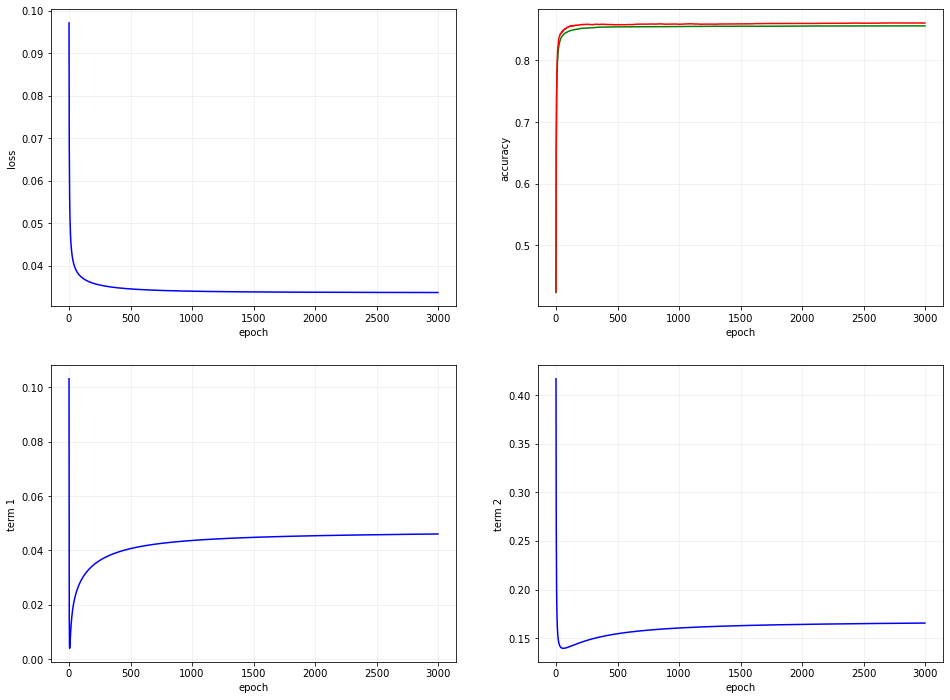

In [8]:
fig, axs = plt.subplots(2, 2, figsize = (16, 12))

axs[0][0].plot(loss_tab, color='blue')
axs[0][1].plot(train_accuracy_tab, color='green')
axs[0][1].plot(test_accuracy_tab, color='red')

axs[1][0].plot(term_I_tab, color = 'blue')
axs[1][1].plot(term_II_tab, color = 'blue')

for row in axs:
    for ax in row:
        ax.grid(True, alpha =0.2)
        ax.set_xlabel('epoch')
        #ax.set_yscale('log')

axs[0][0].set_ylabel('loss')
axs[0][1].set_ylabel('accuracy')
axs[1][0].set_ylabel('term 1')
axs[1][1].set_ylabel('term 2')
plt.show()



## Visualization of mapping of the model

In [12]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

N = 256
vals = np.ones((N, 4))
vals[:, 0] = np.linspace(255/256, 1, N)    ## red  255,192, 203
vals[:, 1] = np.linspace(192/256, 1, N)
vals[:, 2] = np.linspace(203/256, 1, N)  ## blue 75, 0, 130
Pinks = ListedColormap(vals)


top = cm.get_cmap(Pinks, 256)
bottom = cm.get_cmap('Purples', 256)

newcolors = np.vstack((top(np.linspace(0, 1, 256)),
                       bottom(np.linspace(0, 1, 256))))

newcmp = ListedColormap(newcolors, name='PinkPueple')

In [13]:
params=[]
for param in model.parameters():
    params.append(param.detach().numpy())
w1=params[0] 
w2=params[1]


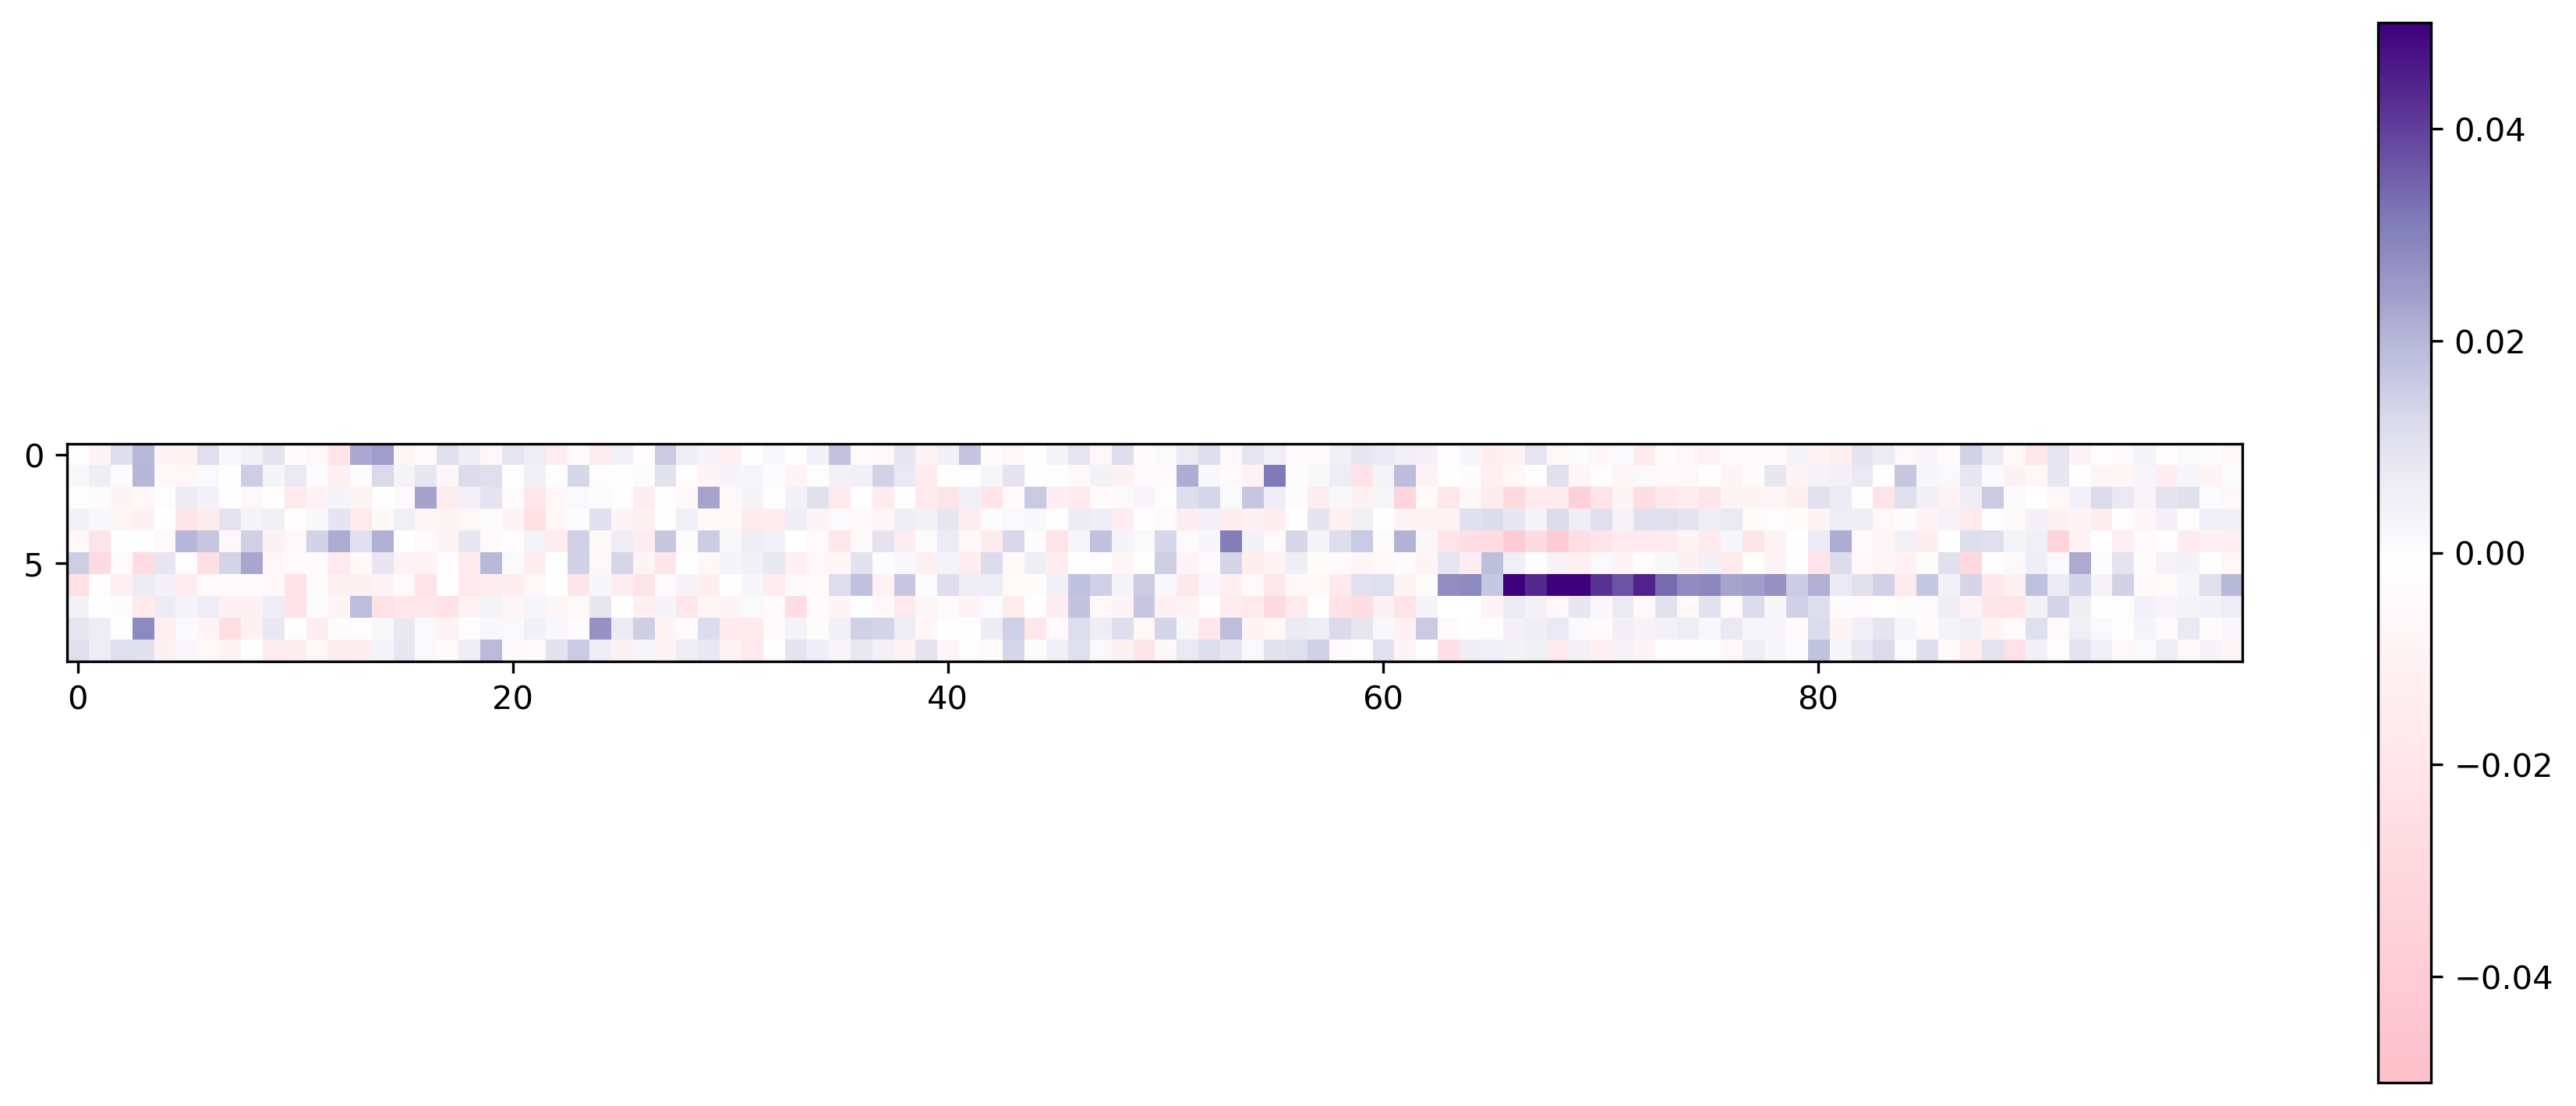

In [14]:
from matplotlib.pyplot import figure
figure(figsize=(15, 6), dpi=300)

WW =  w2 @ w1 
plt.imshow( WW[:100,:100], cmap = newcmp, vmin=-0.05, vmax=0.05)
plt.colorbar()
plt.show()


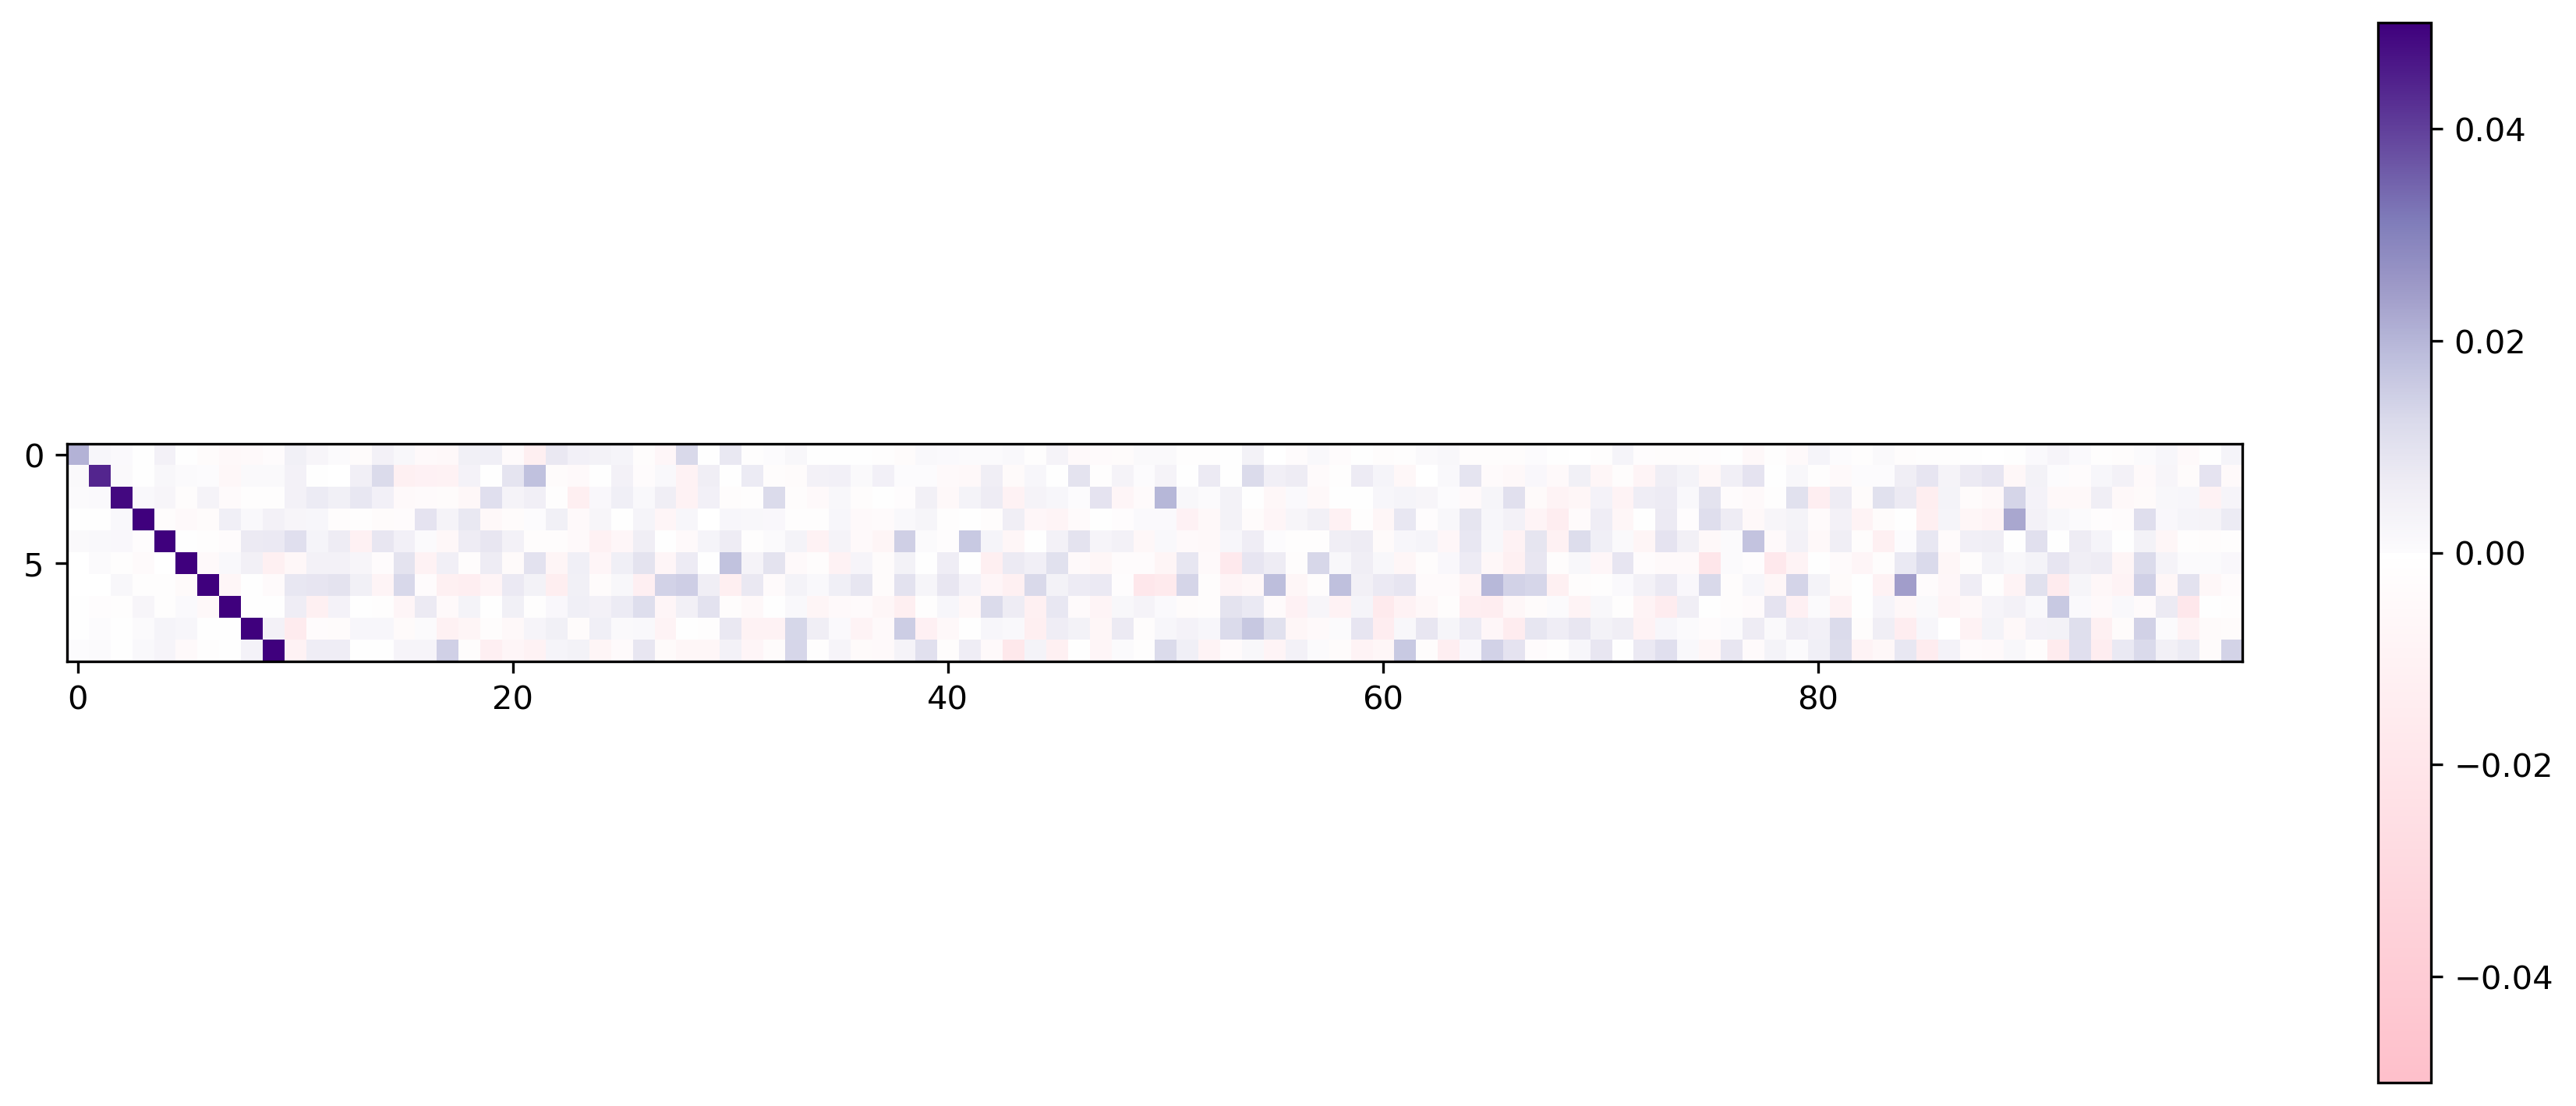

In [15]:
from matplotlib.pyplot import figure
figure(figsize=(15, 6), dpi=300)

WW = U_matrix.T @ w2 @ w1 @ V_matrix
plt.imshow( WW[:100,:100], cmap = newcmp, vmin=-0.05, vmax=0.05)
plt.colorbar()
plt.show()


CHECK: $$MSE = \frac{1}{P} \sum_{\mu=1}^P \lVert y-\hat{y} \rVert ^2 $$
$$ MSE= \frac{1}{P} \sum_{\mu=1}^P \lVert y - W^2 W^1 x \rVert ^2 $$ 

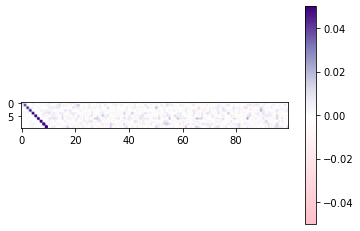

In [16]:
R = U_matrix.T @ w2 @ w1 @ V_matrix
plt.imshow( R[:, :100], cmap = newcmp, vmin=-0.05, vmax=0.05)
plt.colorbar()
plt.show()

## Calculation of terms

In [17]:
term_1 = 0
for alpha in range(10):
    term_1 += (R[alpha][alpha] - S31_matrix[alpha]/S11_matrix[alpha][alpha])**2 * S11_matrix[alpha][alpha]
term_1



array([0.04603857])

In [18]:
term_2 = 0
for beta in range(10):
    for alpha in range(784):
        if(alpha != beta):
            term_2 += (R[beta][alpha])**2 *S11_matrix[alpha][alpha]
term_2


0.16553861511165852

In [19]:
term_3 = np.trace(S33_matrix)
term_3

1.000000009

In [20]:
term_4 = 0
for alpha in range(10):
    term_4+= (S31_matrix[alpha])**2/S11_matrix[alpha][alpha]
term_4   

array([0.49717632])

In [21]:
term_1+term_2+term_3-term_4

array([0.71440088])

In [22]:
term_3-term_4

array([0.50282369])

## terms with star: $T_1^*$,  $T_2^*$,  $T_4^*$

In [23]:
term_4 = 0
for alpha in range(10):
    term_4+= (R[alpha][alpha])**2*S11_matrix[alpha][alpha]
term_4   

0.7849329384861765

In [24]:
term_3-term_4

0.21506707051382357

In [25]:
term_2+term_3-term_4

0.380605685625482

In [26]:
term_1+term_2+term_3-term_4

array([0.42664425])

# Final MSE on training / testing dataset


In [27]:
MSE_tab=[]
SE_model_tab=[]
SE_calc_tab=[]

batch_size: int = 1  
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

In [28]:
with torch.no_grad():
    for i, (x,y) in enumerate(train_loader):
        
        y=F.one_hot(y, num_classes=10).float()
        y_model = model(x)
        
        MSE = criterion(y_model, y)
        SE_model = np.linalg.norm(y_model - y)**2
        
        x=x.detach().numpy().flatten()
        y=y.detach().numpy().flatten()
        
        y_calc = w2 @ w1 @ x
        SE_calc = np.linalg.norm(y_calc - y)**2

        MSE_tab.append(float(MSE))
        SE_model_tab.append(float(SE_model))
        SE_calc_tab.append(float(SE_calc))

        #print(i,"\tMSE = {:.6f} \tSE_model = {:.6f}\tSEcalc = {:.6f}".format(MSE, SE_model, SE_calc))
        
mean_MSE = sum(MSE_tab)/len(MSE_tab)
mean_SE_model = sum(SE_model_tab)/len(SE_model_tab)
mean_SE_calc = sum(SE_calc_tab)/len(SE_calc_tab)

print("Mean square error evaluated on training set")
print("MSE = {:.6f} \tMSE_model = {:.6f}\tMSEcalc = {:.6f}".format(mean_MSE, mean_SE_model, mean_SE_calc))

Mean square error evaluated on training set
MSE = 0.038233 	MSE_model = 0.382333	MSEcalc = 0.382333


In [29]:
with torch.no_grad():
    for i, (x,y) in enumerate(test_loader):
        
        y=F.one_hot(y, num_classes=10).float()
        y_model = model(x)
        
        MSE = criterion(y_model, y)
        SE_model = np.linalg.norm(y_model - y)**2
        
        x=x.detach().numpy().flatten()
        y=y.detach().numpy().flatten()
        
        y_calc =  w2 @ w1 @ x
        SE_calc = np.linalg.norm(y_calc - y)**2

        MSE_tab.append(float(MSE))
        SE_model_tab.append(float(SE_model))
        SE_calc_tab.append(float(SE_calc))

        #print(i,"\tMSE = {:.6f} \tSE_model = {:.6f}\tSEcalc = {:.6f}".format(MSE, SE_model, SE_calc))
        
mean_MSE = sum(MSE_tab)/len(MSE_tab)
mean_SE_model = sum(SE_model_tab)/len(SE_model_tab)
mean_SE_calc = sum(SE_calc_tab)/len(SE_calc_tab)

print("Mean square error evaluated on test set")
print("MSE = {:.6f} \tMSE_model = {:.6f}\tMSEcalc = {:.6f}".format(mean_MSE, mean_SE_model, mean_SE_calc))

Mean square error evaluated on test set
MSE = 0.038245 	MSE_model = 0.382450	MSEcalc = 0.382450


# Save all


In [30]:
import pandas as pd

savefile = 'ground_energy_400.csv'
df = pd.DataFrame()

df['loss'] = loss_tab
df['train_accuracy'] = train_accuracy_tab
df['test_accuracy'] = test_accuracy_tab

df['w1_mean'] = w1_mean_tab
df['w1_std'] = w1_std_tab
df['w2_mean'] = w2_mean_tab
df['w2_std'] = w2_std_tab


df['term_I'] = term_I_tab
df['term_II'] = term_II_tab
df['term_IV'] = term_IV_tab
df['R'] = R_tab


df.to_csv(savefile, index=False)

df_w2= pd.DataFrame(np.array(w2_tab).T)
df_w3= pd.DataFrame(np.array(w3_tab).T)

df_w2.to_csv('ground_energy_400_w2.csv', index=False)
df_w3.to_csv('ground_energy_400_w3.csv', index=False)


In [31]:
w1=deepcopy(model.parameters()[0]).detach().numpy().reshape(input_dim*hidden_dim1)
w2=deepcopy(model.parameters()[1]).detach().numpy().reshape(hidden_dim1*output_dim)

df_w1 = pd.DataFrame(w1, columns = ['w1'] )
df_w2 = pd.DataFrame(w2, columns = ['w2'] )

df_w1.to_csv('w1.csv', index=False)
df_w2.to_csv('w2.csv', index=False)
